In [1]:
# Preprocessing - Day 0 Zebrafish scRNA-seq
#This notebook performs preprocessing, quality control, normalization, and scaling for Day 0 zebrafish caudal fin regeneration single-cell RNA-seq data.
#Series GSE261907-GEO omnibus

In [2]:
# =============================================
# Import Libraries & Set Up Environment
# =============================================
import scanpy as sc          # Single-cell analysis toolkit
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns        # Enhanced visualizations
import pandas as pd          # Data manipulation
import numpy as np           # Numerical operations

# =============================================
# Configure Visualization Settings
# =============================================
# Scanpy settings for figures (high-quality saves)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300)

# Seaborn style for clean, grid-based plots
sns.set(style="whitegrid")

In [3]:
# =============================================
# Load 10x Genomics scRNA-seq Data
# =============================================
adata = sc.read_10x_mtx(
    "E:/Informatics project/Zebrafish fin regeneration/data/0 DPA 1st REP",  # Directory containing matrix.mtx, genes.tsv, and barcodes.tsv
    var_names='gene_symbols',  # Use gene symbols (instead of Ensembl IDs) as variable names
    cache=True                # Cache the data for faster reloading
)

# Ensure unique gene names (avoids duplicates like 'GeneA-1', 'GeneA-2')
adata.var_names_make_unique()

# Display the AnnData object (shows cell x gene matrix dimensions and metadata)
adata

AnnData object with n_obs × n_vars = 8315 × 27407
    var: 'gene_ids', 'feature_types'

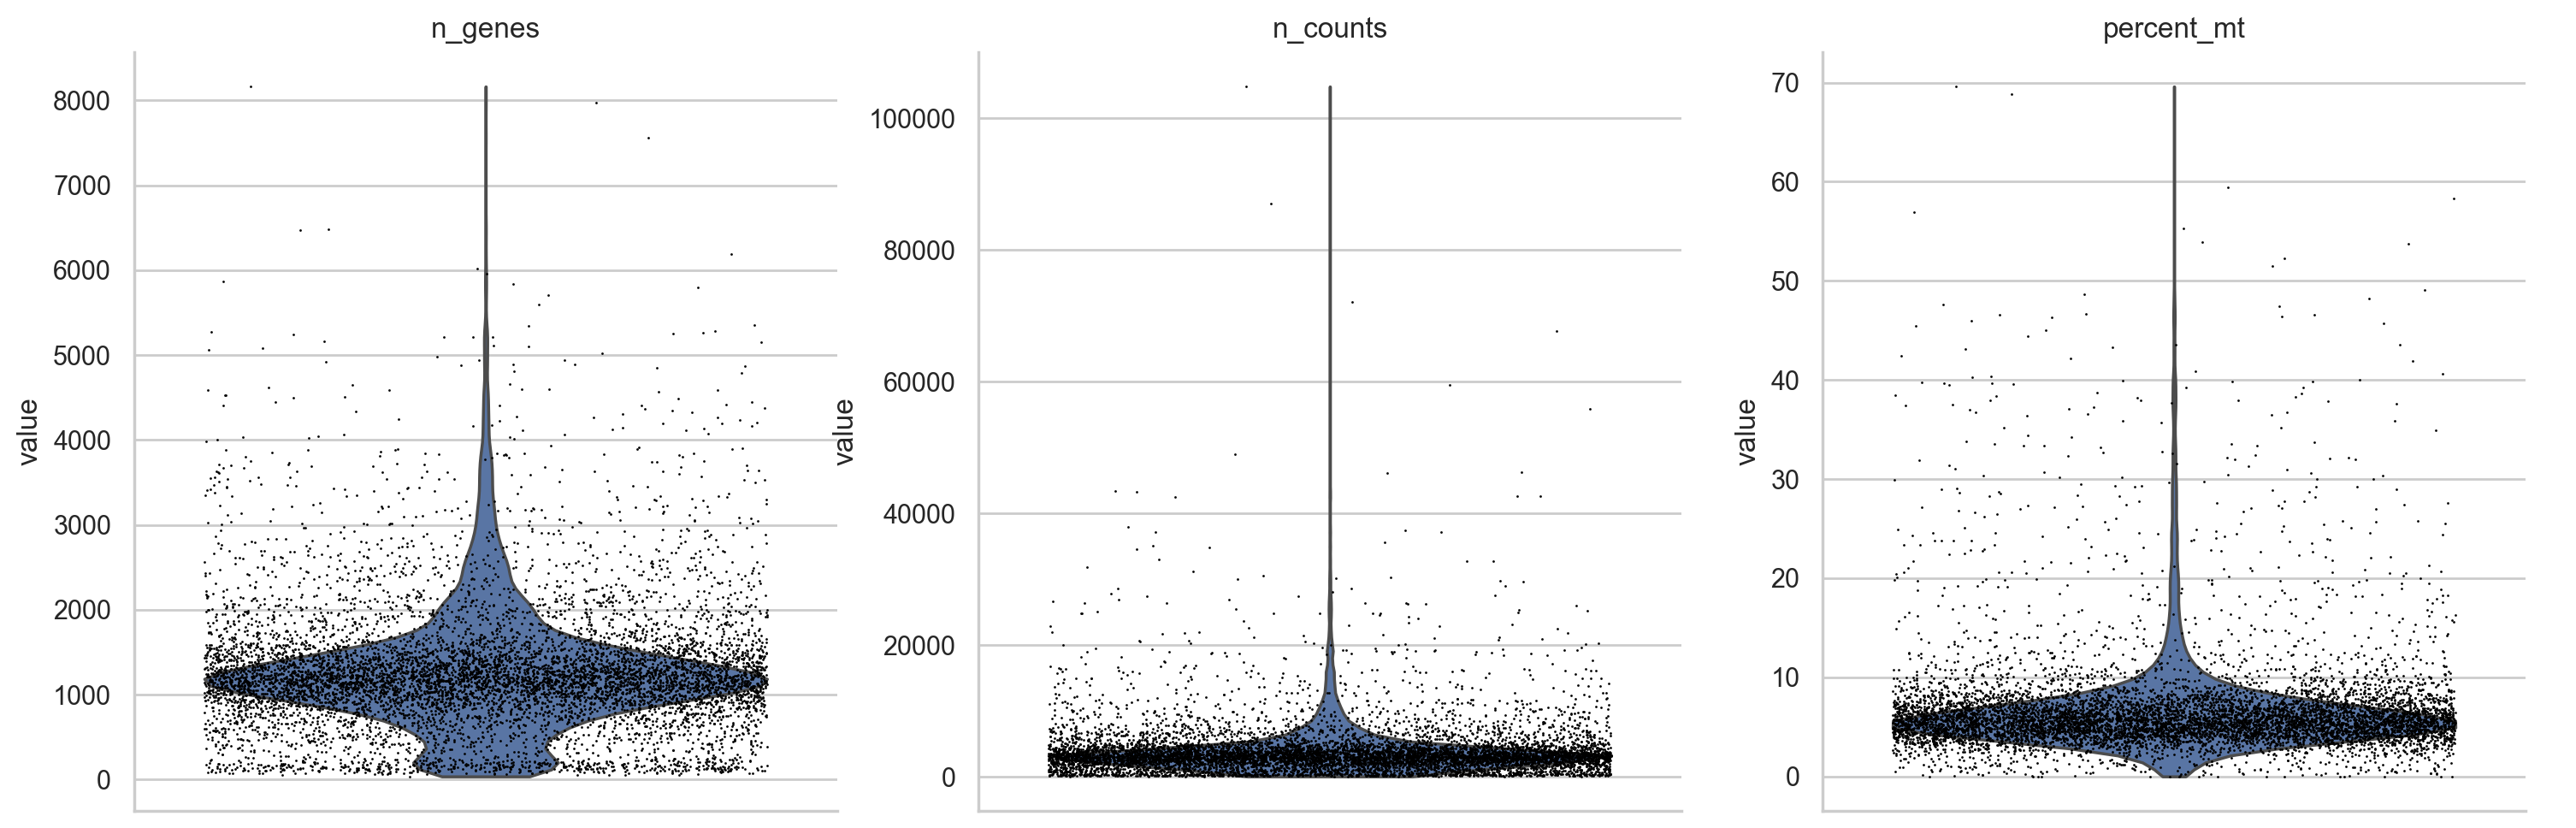


🔍 QC Summary Statistics:

           n_genes       n_counts   percent_mt
count  8315.000000    8315.000000  8315.000000
mean   1272.626819    3882.624268     6.708830
std     748.415332    4281.270508     5.280879
min      37.000000      53.000000     0.000000
25%     903.000000    2053.500000     4.411490
50%    1181.000000    3069.000000     5.633047
75%    1486.000000    4278.000000     7.158697
max    8163.000000  104815.000000    69.603523


In [4]:
# =============================================
# Calculate Basic QC Metrics
# =============================================
# Total counts (UMIs) per cell
adata.obs['n_counts'] = adata.X.sum(axis=1).A1  

# Number of genes detected per cell (non-zero counts)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1  

# =============================================
# Mitochondrial Gene Percentage (Optional but Recommended)
# =============================================
# Identify mitochondrial genes (prefix 'mt-' in gene symbols)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  

# Calculate % mitochondrial reads per cell
adata.obs['percent_mt'] = (
    np.sum(adata[:, adata.var['mt']].X, axis=1).A1 / adata.obs['n_counts'] * 100
)

# =============================================
# Visualize QC Metrics
# =============================================
# Violin plots for n_genes, n_counts, and percent_mt
sc.pl.violin(
    adata, 
    ['n_genes', 'n_counts', 'percent_mt'], 
    jitter=0.4,  # Add jitter for better visibility of data points
    multi_panel=True  # Split into subplots
)

# =============================================
# Display QC Summary Statistics
# =============================================
qc_summary = adata.obs[['n_genes', 'n_counts', 'percent_mt']].describe()
print("\n🔍 QC Summary Statistics:\n")
print(qc_summary)

In [5]:
# =============================================
# Apply Quality Control Filters
# =============================================
# Filter cells based on detected genes (remove low-quality cells and potential doublets)
adata = adata[adata.obs['n_genes'] > 500, :]      # Minimum 500 genes/cell
adata = adata[adata.obs['n_genes'] < 5000, :]     # Maximum 5000 genes/cell (doublet threshold)

# Filter based on sequencing depth (UMI counts)
adata = adata[adata.obs['n_counts'] > 500, :]    # Minimum 500 UMIs/cell
adata = adata[adata.obs['n_counts'] < 27000, :]   # Maximum 27000 UMIs/cell (outlier threshold)

# Filter based on mitochondrial gene percentage
adata = adata[adata.obs['percent_mt'] < 10, :]   # <10% mitochondrial reads

# =============================================
# Post-Filtering Validation
# =============================================
print(f"✅ Final number of cells after filtering: {adata.n_obs}")
# =============================================
# Biological Considerations (Comment)
# =============================================
# Note: In regeneration studies, some cells may naturally have:
# - Higher metabolic activity → slightly elevated mtDNA %
# - Actively dividing cells → higher RNA content
# Adjust thresholds accordingly for your biological context.

✅ Final number of cells after filtering: 7054


C:\Users\uer\anaconda3\envs\scenv\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


✅ Selected 3645 highly variable genes
🔒 Forced inclusion of genes: ['taf1b', 'rrn3', 'sprtn', 'polr1d']


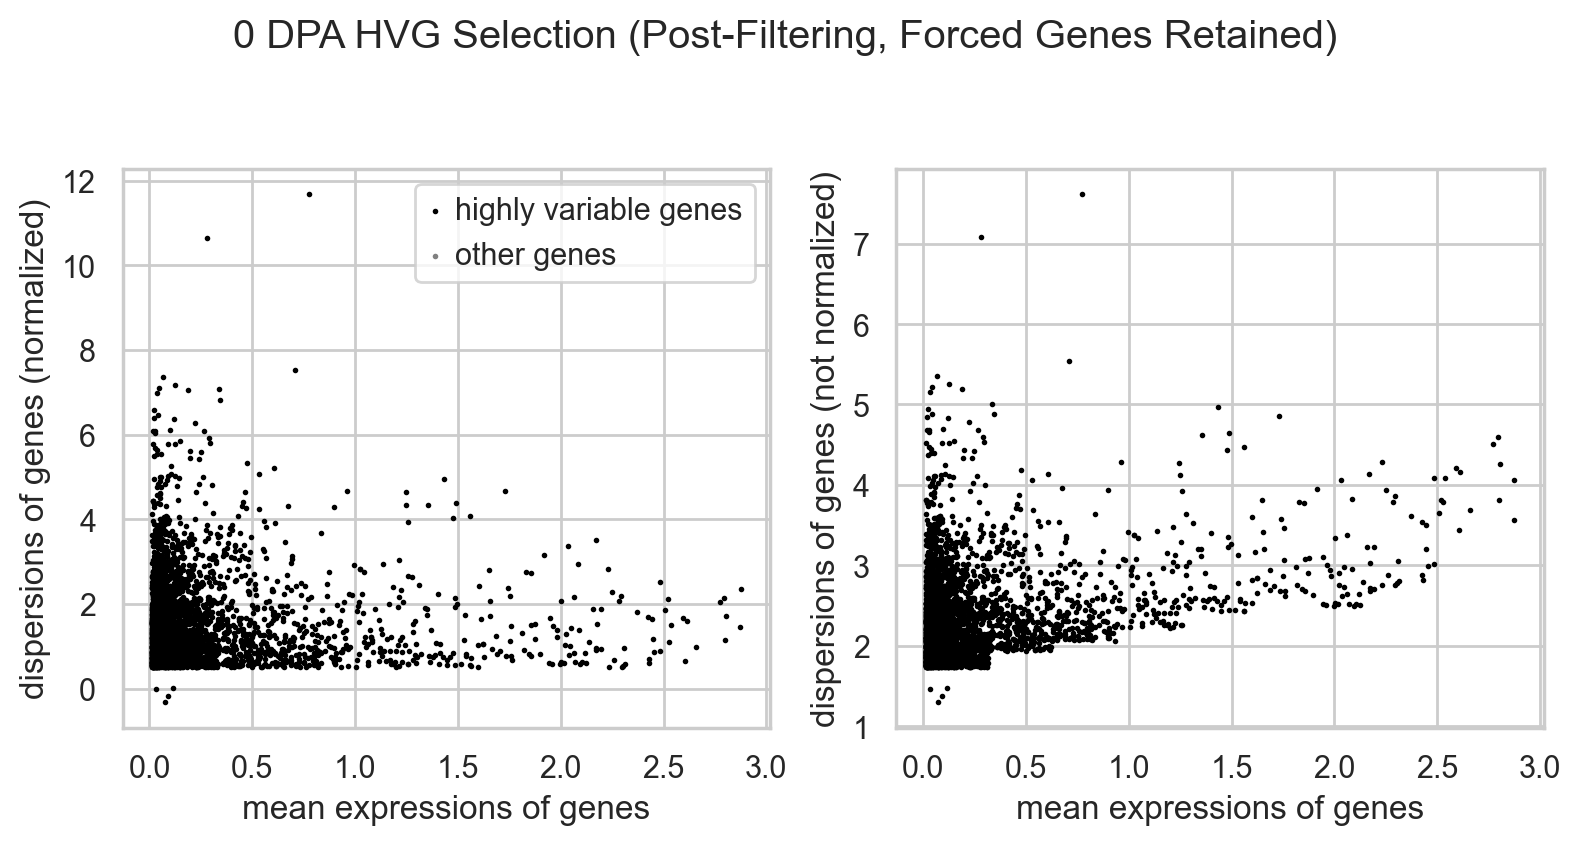

In [6]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# =============================================
# Data Normalization
# =============================================
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize per cell
sc.pp.log1p(adata)  # Log-transform

# =============================================
# Highly Variable Gene Selection
# =============================================
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)

# =============================================
# Force Retain Specific Genes (RNA Pol I-related)
# =============================================
genes_to_keep = ['taf1b', 'rrn3', 'sprtn','polr1d']  # Add additional genes here as needed

# Make sure genes exist in your dataset and case sensitivity matches
genes_present = [gene for gene in genes_to_keep if gene in adata.var_names]

# Update HVG flag manually for these genes
adata.var.loc[genes_present, 'highly_variable'] = True

print(f"✅ Selected {sum(adata.var.highly_variable)} highly variable genes")
print(f"🔒 Forced inclusion of genes: {genes_present}")

# =============================================
# Subset to Highly Variable Genes (including forced ones)
# =============================================
adata = adata[:, adata.var.highly_variable]

# =============================================
# Biological Validation Plot
# =============================================
sc.pl.highly_variable_genes(adata, show=False)
plt.suptitle("0 DPA HVG Selection (Post-Filtering, Forced Genes Retained)", y=1.05)
plt.tight_layout()

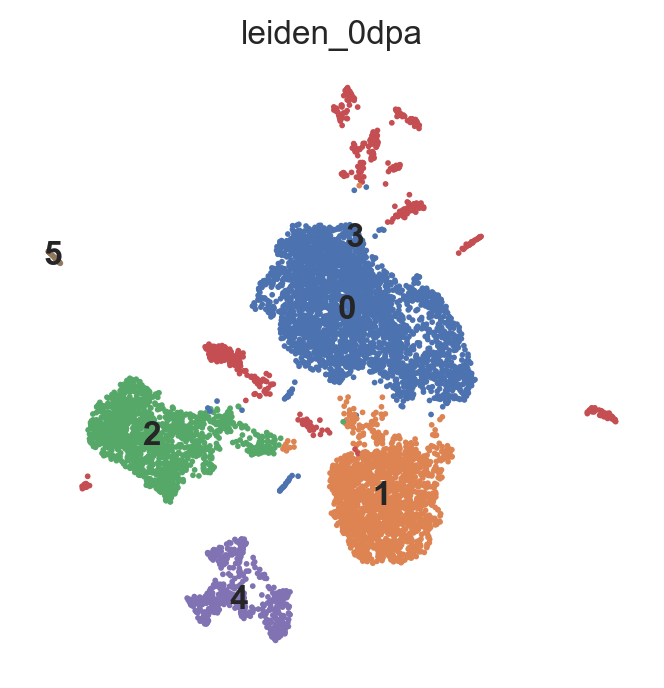

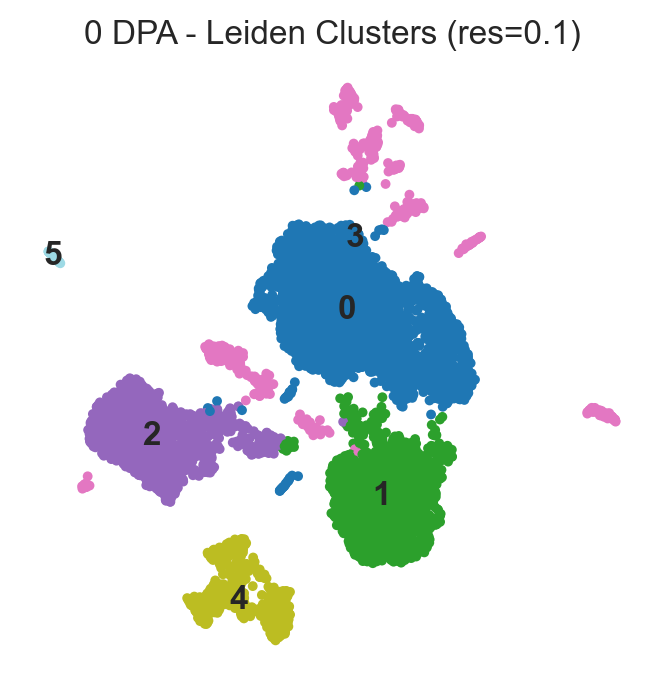

In [8]:
# =============================================
# Feature Scaling (Optional)
# =============================================
# Scale data to unit variance and zero mean (clip values >10 to reduce outlier impact)
sc.pp.scale(adata, max_value=10)  # Recommended for PCA but can be memory-intensive

# =============================================
# Principal Component Analysis (PCA)
# =============================================
# Reduce dimensionality to 50 PCs (default) using ARPACK solver
sc.tl.pca(adata, svd_solver='arpack')  

# =============================================
# Nearest-Neighbor Graph Construction
# =============================================
# Build KNN graph for clustering (using 40 PCs and 10 neighbors)
sc.pp.neighbors(
    adata, 
    n_neighbors=10,   # Local connectivity parameter
    n_pcs=40          # Number of PCs to use
)

# =============================================
# Clustering with Leiden Algorithm
# =============================================
# Detect cell communities (low resolution = fewer clusters)
sc.tl.leiden(
    adata,
    resolution=0.05,   # Cluster granularity (lower = fewer clusters)
    key_added='leiden_0dpa'  # Store results in adata.obs['leiden_01']
)

# =============================================
# UMAP Visualization
# =============================================
# Non-linear dimensionality reduction for visualization
sc.tl.umap(adata)  

# Plot UMAP colored by Leiden clusters
sc.pl.umap(
    adata, 
    color=['leiden_0dpa'],  # Color by cluster assignment
    frameon=False,       # Cleaner visualization (optional)
    legend_loc='on data' # Show cluster IDs on plot (optional)
)

# Plot with regeneration-relevant aesthetics
#Optional
sc.pl.umap(
    adata,
    color=['leiden_0dpa'],
    palette='tab20',  # More distinct colors
    frameon=False,
    legend_loc='on data',
    size=50,  # Larger points for visibility
    title='0 DPA - Leiden Clusters (res=0.1)',
)

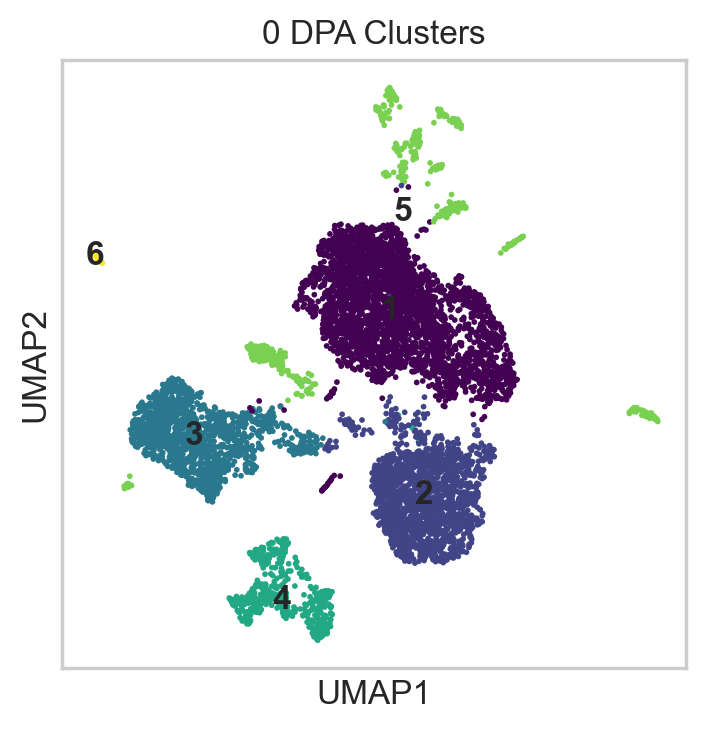

In [9]:
# =============================================
# Cluster Label Formatting
# =============================================
# Convert cluster labels to string type (required for plotting)
adata.obs['leiden_01'] = adata.obs['leiden_01'].astype(int).astype(str)  

# Shift cluster numbering to start at 1 (instead of 0)
adata.obs['leiden_01'] = (adata.obs['leiden_01'].astype(int) + 1).astype(str)

# =============================================
# Visualize Updated Clustering
# =============================================
sc.pl.umap(
    adata, 
    color='leiden_01',          # Color by adjusted cluster labels
    legend_loc='on data',       # Display labels directly on plot
    title='0 DPA Clusters',  # Clear plot title
    palette='viridis'           # Optional: Use colorblind-friendly palette
)

In [10]:
# =============================================
# Basic QC Metrics Summary
# =============================================
print(
    f"\n✅ Baseline QC Summary:\n"
    f"• Cells after filtering: {adata.n_obs:,}\n"
    f"• Median genes per cell: {np.median(adata.obs['n_genes']):.0f}\n"
    f"• Median UMIs per cell: {np.median(adata.obs['n_counts']):,}"
)

# =============================================
# Cluster Composition Analysis
# =============================================
# Count cells per cluster (sorted by cluster number)
print("\n🔬 Cluster Composition (0 DPA):")
print(
    adata.obs['leiden_01']
    .value_counts()
    .sort_index()
    .to_string()  # Cleaner output than default print
)

# =============================================
# Cluster-level QC Metrics
# =============================================
# Calculate median genes and UMIs per cluster
cluster_stats = (
    adata.obs
    .groupby('leiden_01')[['n_genes', 'n_counts']]
    .median()
    .rename(columns={
        'n_genes': 'Median Genes',
        'n_counts': 'Median UMIs'
    })
)

print("\n📊 Cluster Quality Metrics:")
print(cluster_stats.to_markdown(tablefmt="github"))  # GitHub-friendly formatting
# Note: The following code needs 'tabulate' for GitHub-friendly tables.
# If missing, install it via: pip install tabulate


✅ Baseline QC Summary:
• Cells after filtering: 7,054
• Median genes per cell: 1240
• Median UMIs per cell: 3,308.0

🔬 Cluster Composition (0 DPA):
leiden_01
1    3105
2    1606
3    1339
4     492
5     488
6      24

📊 Cluster Quality Metrics:
|   leiden_01 |   Median Genes |   Median UMIs |
|-------------|----------------|---------------|
|           1 |         1231   |        3234   |
|           2 |         1337   |        3833   |
|           3 |         1251   |        3332   |
|           4 |          952.5 |        2046.5 |
|           5 |         1058   |        2127   |
|           6 |         1238   |        2428.5 |


C:\Users\uer\AppData\Local\Temp\ipykernel_38584\95580233.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('leiden_01')[['n_genes', 'n_counts']]


In [11]:
# =============================================
# Add Experimental Metadata to AnnData Object
# =============================================
# Time point annotation (crucial for time-series analysis)
adata.obs['time_point'] = '0dpa'  # Options: '0dpa', '1dpa', '2dpa', etc.

In [12]:
# =============================================
# Save Processed 0 DPA Data
# =============================================
adata.write(
    "0_DPA.h5ad",          # Output filename
   # compression="gzip"     # Optional: Reduce file size (~50% smaller)
)

print(f"✅ Successfully saved preprocessed data to '0dpa1.h5ad':")
print(f"   - Cells: {adata.n_obs:,}")
print(f"   - Genes: {adata.n_vars:,}")


✅ Successfully saved preprocessed data to '0dpa1.h5ad':
   - Cells: 7,054
   - Genes: 3,645


In [13]:
# =============================================
# Workflow Summary 
# =============================================

## 0 DPA PROCESSING PIPELINE:
#1. Load Data          : Read 10X Genomics MTX files
#2. Quality Control    : Filter cells (genes >200, UMIs >500, mtDNA <10%)
#3. Normalization      : Total-count (1e4) + log1p
#4. Feature Selection  : HVGs (min_mean=0.0125, max_mean=3)
#5. Dimensionality     : PCA (50 PCs) → Leiden clustering (res=0.05)
#6. Visualization      : UMAP with 1-indexed clusters
#7. Data Export        : Saved as compressed H5AD
